In [1]:
from dask.distributed import Client

client = Client("tcp://127.0.0.1:45787")
client

<Client: 'tcp://127.0.0.1:45787' processes=8 threads=32, memory=187.54 GiB>

In [2]:
import numpy as np
import xarray as xr
import os.path as op
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
ddir = '/bettik/uchidat/qg-ML/'

In [4]:
U     = .1
T     = 5e5    # seconds
L     = U*T
tau0  = .0001
dt    = 5e-2
Rd    = 5e4   # Rossby radius (50km)
Re4   = 4e3
# f0 = 8e-5
beta  = .5
N     = 1024   # Number of horizontal grids
L0    = 80
H     = 5e3
dx    = L0/N  # Non-dimensionalized horizontal resolution ((L0*Rd)/N)/Rd
diny  = 360
Rom   = .025
Ekb   = .002*2
ntime = int(62.2*5)+1

percent = 20
nmemb = 100

ncoars = 4
DX = dx * ncoars

$$ \epsilon = \frac{J^C - J^C_\text{reconstructed}}{|J^C|} $$

In [17]:
dsp1 = xr.open_dataset(op.join(ddir,"Eddy-n04_001.nc")
                      ).chunk({'time':9,'YC':128,'XC':128})
dsp1

<xarray.Dataset>
Dimensions:  (XC: 256, YC: 256, Z: 3, time: 312)
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * Z        (Z) float64 0.03 0.13 0.6
    drF      (Z) float64 dask.array<chunksize=(3,), meta=np.ndarray>
  * time     (time) float64 311.0 312.0 313.0 314.0 ... 619.0 620.0 621.0 622.0
Data variables:
    upqp     (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    vpqp     (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    upP0p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    vpP0p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    upP1p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    vpP1p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    upP2p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    vpP2p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    upP3p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>
    vpP3p    (time, Z, YC, XC) float32 dask.array<chunksize=(9, 3, 128, 128), meta=np.ndarray>

In [18]:
dsb1 = xr.open_dataset(op.join(ddir,"Mean-n04_001.nc")
                      ).chunk({'time':9,'YC':128,'XC':128})
dsb1

,Array,Chunk
Bytes,237.67 MiB,1.69 MiB
Shape,"(312, 3, 258, 258)","(9, 3, 128, 128)"
Count,316 Tasks,315 Chunks
Type,float32,numpy.ndarray
,Array,Chunk
Bytes,237.67 MiB,1.69 MiB
Shape,"(312, 3, 258, 258)","(9, 3, 128, 128)"
Count,316 Tasks,315 Chunks
Type,float32,numpy.ndarray
,Array,Chunk


In [19]:
K = xr.open_zarr(op.join(ddir,'Diff-tensor/nC%02d/%010d.zarr'
                         % (ncoars,0))
                ).K
K

<xarray.DataArray 'K' (Z: 3, YC: 256, XC: 256, col: 2, row: 2)>
dask.array<open_dataset-4f5b06e692cffbf5755332ec6bf287b5K, shape=(3, 256, 256, 2, 2), dtype=float64, chunksize=(2, 128, 128, 1, 2), chunktype=numpy.ndarray>
Coordinates:
  * XC       (XC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * YC       (YC) float64 0.1562 0.4688 0.7812 1.094 ... 78.91 79.22 79.53 79.84
  * Z        (Z) float64 0.03 0.13 0.6
Dimensions without coordinates: col, row

In [20]:
P0 = dsb1.P0b.data   
P0x = np.diff(P0[...,1:-1,:], axis=-1) / DX
P0x = xr.DataArray(.5*(P0x[...,1:] + P0x[...,:-1]), 
                   dims=dsb1.P0b.dims, 
                   coords=dsb1.P0b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})
P0y = np.diff(P0[...,1:-1], axis=-2) / DX
P0y = xr.DataArray(.5*(P0y[...,1:,:] + P0y[...,:-1,:]), 
                   dims=dsb1.P0b.dims, 
                   coords=dsb1.P0b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})

P1 = dsb1.P1b.data
P1x = np.diff(P1[...,1:-1,:], axis=-1) / DX
P1x = xr.DataArray(.5*(P1x[...,1:] + P1x[...,:-1]), 
                   dims=dsb1.P1b.dims, 
                   coords=dsb1.P1b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})
P1y = np.diff(P1[...,1:-1], axis=-2) / DX
P1y = xr.DataArray(.5*(P1y[...,1:,:] + P1y[...,:-1,:]), 
                   dims=dsb1.P1b.dims, 
                   coords=dsb1.P1b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})

P2 = dsb1.P2b.data
P2x = np.diff(P2[...,1:-1,:], axis=-1) / DX
P2x = xr.DataArray(.5*(P2x[...,1:] + P2x[...,:-1]), 
                   dims=dsb1.P2b.dims, 
                   coords=dsb1.P2b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})
P2y = np.diff(P2[...,1:-1], axis=-2) / DX
P2y = xr.DataArray(.5*(P2y[...,1:,:] + P2y[...,:-1,:]), 
                   dims=dsb1.P2b.dims, 
                   coords=dsb1.P2b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})

P3 = dsb1.P3b.data  
P3x = np.diff(P3[...,1:-1,:], axis=-1) / DX
P3x = xr.DataArray(.5*(P3x[...,1:] + P3x[...,:-1]), 
                   dims=dsb1.P3b.dims, 
                   coords=dsb1.P3b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})
P3y = np.diff(P3[...,1:-1], axis=-2) / DX
P3y = xr.DataArray(.5*(P3y[...,1:,:] + P3y[...,:-1,:]), 
                   dims=dsb1.P3b.dims, 
                   coords=dsb1.P3b.isel(YC=slice(1,-1),
                                        XC=slice(1,-1)).coords
                  ).chunk({'YC':128,'XC':128})

In [26]:
Fx0 = -(K[...,0,0] * P0x.isel(time=0)
        + K[...,1,0] * P0y.isel(time=0)
       )
ex0 = (dsp1.upP0p.isel(time=0) - Fx0) / (dsp1.upP0p.isel(time=0))

Fy0 = -(K[...,0,1] * P0x.isel(time=0)
        + K[...,1,1] * P0y.isel(time=0)
       )
ey0 = (dsp1.vpP0p.isel(time=0) - Fy0) / (dsp1.vpP0p.isel(time=0))
############################################################
Fx1 = -(K[...,0,0] * P1x.isel(time=0)
        + K[...,1,0] * P1y.isel(time=0)
       )
ex1 = (dsp1.upP1p.isel(time=0) - Fx1) / (dsp1.upP1p.isel(time=0))

Fy1 = -(K[...,0,1] * P1x.isel(time=0)
        + K[...,1,1] * P1y.isel(time=0)
       )
ey1 = (dsp1.vpP1p.isel(time=0) - Fy1) / (dsp1.vpP1p.isel(time=0))
############################################################
Fx2 = -(K[...,0,0] * P2x.isel(time=0)
        + K[...,1,0] * P2y.isel(time=0)
       )
ex2 = (dsp1.upP2p.isel(time=0) - Fx2) / (dsp1.upP2p.isel(time=0))

Fy2 = -(K[...,0,1] * P2x.isel(time=0)
        + K[...,1,1] * P2y.isel(time=0)
       )
ey2 = (dsp1.vpP2p.isel(time=0) - Fy2) / (dsp1.vpP2p.isel(time=0))
############################################################
Fx3 = -(K[...,0,0] * P3x.isel(time=0)
        + K[...,1,0] * P3y.isel(time=0)
       )
ex3 = (dsp1.upP3p.isel(time=0) - Fx3) / (dsp1.upP3p.isel(time=0))

Fy3 = -(K[...,0,1] * P3x.isel(time=0)
        + K[...,1,1] * P3y.isel(time=0)
       )
ey3 = (dsp1.vpP3p.isel(time=0) - Fy3) / (dsp1.vpP3p.isel(time=0))

In [29]:
Q = dsb1.qb.data   
Qx = np.diff(Q[...,1:-1,:], axis=-1) / DX
Qx = xr.DataArray(.5*(Qx[...,1:] + Qx[...,:-1]), 
                  dims=dsb1.qb.dims, 
                  coords=dsb1.qb.isel(YC=slice(1,-1),
                                      XC=slice(1,-1)).coords
                 ).chunk({'YC':128,'XC':128})
Qy = np.diff(Q[...,1:-1], axis=-2) / DX
Qy = xr.DataArray(.5*(Qy[...,1:,:] + Qy[...,:-1,:]), 
                  dims=dsb1.qb.dims, 
                  coords=dsb1.qb.isel(YC=slice(1,-1),
                                      XC=slice(1,-1)).coords
                 ).chunk({'YC':128,'XC':128})

In [30]:
FxQ = -(K[...,0,0] * Qx.isel(time=0)
        + K[...,1,0] * Qy.isel(time=0)
       )
exq = (dsp1.upqp.isel(time=0) - FxQ) / (dsp1.upqp.isel(time=0))

FyQ = -(K[...,0,1] * Qx.isel(time=0)
        + K[...,1,1] * Qy.isel(time=0)
       )
eyq = (dsp1.vpqp.isel(time=0) - FyQ) / (dsp1.vpqp.isel(time=0))

/tmp/ipykernel_26441/317770246.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_26441/317770246.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_26441/317770246.py:16: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilate

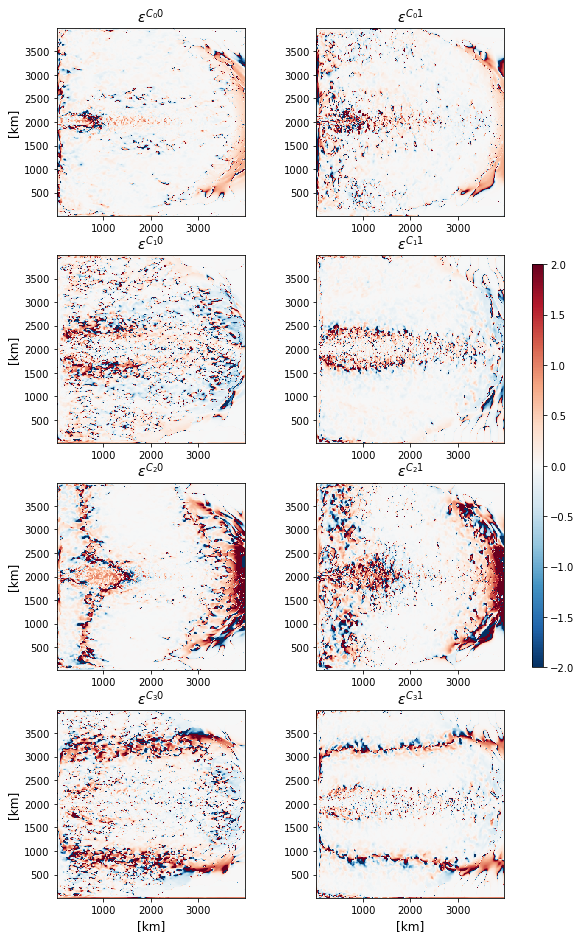

In [37]:
l = 0
fig, axes = plt.subplots(figsize=(9,16), nrows=4, ncols=2)

im = axes[0,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                          ex0.isel(Z=l),
                          cmap='RdBu_r', 
                          vmax=2e0, vmin=-2e0,
                          rasterized=True
                         )
axes[0,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     ey0.isel(Z=l),
                     cmap='RdBu_r', 
                     vmax=2e0, vmin=-2e0,
                     rasterized=True
                    )
axes[1,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     ex1.isel(Z=l),
                     cmap='RdBu_r', 
                     vmax=2e0, vmin=-2e0,
                     rasterized=True
                    )
axes[1,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     ey1.isel(Z=l),
                     cmap='RdBu_r', 
                     vmax=2e0, vmin=-2e0,
                     rasterized=True
                    )
axes[2,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     ex2.isel(Z=l),
                     cmap='RdBu_r', 
                     vmax=2e0, vmin=-2e0,
                     rasterized=True
                    )
axes[2,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     ey2.isel(Z=l),
                     cmap='RdBu_r', 
                     vmax=2e0, vmin=-2e0,
                     rasterized=True
                    )
axes[3,0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     ex3.isel(Z=l),
                     cmap='RdBu_r', 
                     vmax=2e0, vmin=-2e0,
                     rasterized=True
                    )
axes[3,1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     ey3.isel(Z=l),
                     cmap='RdBu_r', 
                     vmax=2e0, vmin=-2e0,
                     rasterized=True
                    )

axes[0,0].set_aspect(1)
axes[1,0].set_aspect(1)
axes[0,1].set_aspect(1)
axes[1,1].set_aspect(1)
axes[2,0].set_aspect(1)
axes[2,1].set_aspect(1)
axes[3,0].set_aspect(1)
axes[3,1].set_aspect(1)
# axes[4,0].set_aspect(1)
# axes[4,1].set_aspect(1)

axes[0,0].set_title(r"$\epsilon^{C_00}$", fontsize=14)
axes[0,1].set_title(r"$\epsilon^{C_01}$", fontsize=14)
axes[1,0].set_title(r"$\epsilon^{C_10}$", 
                    fontsize=14)
axes[1,1].set_title(r"$\epsilon^{C_11}$", 
                    fontsize=14)
axes[2,0].set_title(r"$\epsilon^{C_20}$", 
                    fontsize=14)
axes[2,1].set_title(r"$\epsilon^{C_21}$", 
                    fontsize=14)
axes[3,0].set_title(r"$\epsilon^{C_30}$", 
                    fontsize=14)
axes[3,1].set_title(r"$\epsilon^{C_31}$", 
                    fontsize=14)
# axes[4,0].set_title(r"$\epsilon^{q0}$", 
#                     fontsize=14)
# axes[4,1].set_title(r"$\epsilon^{q1}$", 
#                     fontsize=14)

axes[0,0].set_ylabel(r"[km]", fontsize=12)
axes[1,0].set_ylabel(r"[km]", fontsize=12)
axes[2,0].set_ylabel(r"[km]", fontsize=12)
axes[3,0].set_ylabel(r"[km]", fontsize=12)
# axes[4,0].set_ylabel(r"[km]", fontsize=12)
axes[3,0].set_xlabel(r"[km]", fontsize=12)
axes[3,1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.21)
cbax = fig.add_axes([.88, .325, .018, .35])
cbar = fig.colorbar(im, cax=cbax)
# cbar.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/RelErr_Z=%1d_%010d.pdf' % (l,0)))

In [42]:
l = 2
print(np.median(np.abs(ex0.isel(Z=l))),np.median(np.abs(ey0.isel(Z=l))))
print(np.median(np.abs(ex1.isel(Z=l))),np.median(np.abs(ey1.isel(Z=l))))
print(np.median(np.abs(ex2.isel(Z=l))),np.median(np.abs(ey2.isel(Z=l))))
print(np.median(np.abs(ex3.isel(Z=l))),np.median(np.abs(ey3.isel(Z=l))))
print(np.median(np.abs(exq.isel(Z=l))),np.median(np.abs(eyq.isel(Z=l))))

0.012224568259172522 0.01687591468196474
0.025198563273797325 0.0072143582824500665
0.01894460496453068 0.02799289320057908
0.0373422430183368 0.01115173092489926
0.9992202071722279 0.99680322277074


/tmp/ipykernel_26441/1971208324.py:4: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,
/tmp/ipykernel_26441/1971208324.py:10: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  axes[1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3,


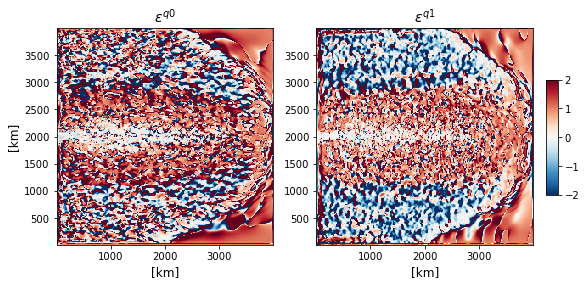

In [39]:
l = 0
fig, axes = plt.subplots(figsize=(9,4), nrows=1, ncols=2)

axes[0].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     exq.isel(Z=l),
                     cmap='RdBu_r', 
                     vmax=2e0, vmin=-2e0,
                     rasterized=True
                    )
axes[1].pcolormesh(K.XC*L*1e-3, K.YC*L*1e-3, 
                     eyq.isel(Z=l),
                     cmap='RdBu_r', 
                     vmax=2e0, vmin=-2e0,
                     rasterized=True
                    )
axes[0].set_aspect(1)
axes[1].set_aspect(1)

axes[0].set_title(r"$\epsilon^{q0}$", 
                    fontsize=14)
axes[1].set_title(r"$\epsilon^{q1}$", 
                    fontsize=14)

axes[0].set_ylabel(r"[km]", fontsize=12)
axes[0].set_xlabel(r"[km]", fontsize=12)
axes[1].set_xlabel(r"[km]", fontsize=12)

fig.subplots_adjust(right=0.86, hspace=.21)
cbax = fig.add_axes([.88, .3, .018, .4])
cbar = fig.colorbar(im, cax=cbax)
# cbar.set_label(r"[m s$^{-1}$]", fontsize=12)

plt.savefig(op.join(ddir,'Figs/RelErrQ_Z=%1d_%010d.pdf' % (l,0)))